## MULTILAYER PERCEPTRON MODEL WITH RUL LIMITATION
This notebook presents de coding to build the Multilayer Perceptron Model with the RUL limition and the implementation over FD001.

In [1]:
## Load basic libraries

from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 
import random
random.seed(123)

#model_path = 'MLP_regression_PCA_1_FD4_tuned.h5'




In [2]:
## Load data science libraries

import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
import keras.backend as Kback
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from math import e
from Perform_function import perform_func
import random




Using TensorFlow backend.


In [3]:
#Data loading

train_df = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/train_FD004.txt", delimiter = ' ')
test_df  = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/test_FD004.txt", delimiter = ' ')
RUL_test = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/RUL_FD004.txt")
RUL_real = RUL_test

In [5]:
## K-Means operating condition identification

#We need to identify every operating mode and standardize it 

kmeans = KMeans(n_clusters = 6, random_state = 0).fit(train_df[['OP1','OP2','OP3']])
train_df['OP_Condition'] = kmeans.labels_

test_df['OP_Condition'] = kmeans.predict(test_df[['OP1','OP2','OP3']])

In [6]:
cols_selected = ['T24', 'T30', 'T50', 'P15', 'P30', 'Nc', 'Ps30', 'BPR','htBleed', 'W31', 'W32']

In [7]:
#######
#Data ingestion & processing
######

#Unuseful columns deleting 

train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)

test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


###TRAIN DATA SET###

# Standarization for both sensor variables

# The cycles are standardized separately attending to their operating condition

train_df['Cycle_norm'] = train_df['Cycle']
cols_normalize = train_df.columns.difference(['Unit','Cycle','UL','RUL','UL_30','UL_50', 'UL_75', 'OP_Condition', 'OP1', 'OP2',])

scaler0 = StandardScaler()
train_df.loc[train_df['OP_Condition']==0, cols_normalize] = scaler0.fit_transform(train_df.loc[train_df['OP_Condition']==0, cols_normalize])

scaler1 = StandardScaler()
train_df.loc[train_df['OP_Condition']==1, cols_normalize] = scaler1.fit_transform(train_df.loc[train_df['OP_Condition']==1, cols_normalize])

scaler2 = StandardScaler()
train_df.loc[train_df['OP_Condition']==2, cols_normalize] = scaler2.fit_transform(train_df.loc[train_df['OP_Condition']==2, cols_normalize])

scaler3 = StandardScaler()
train_df.loc[train_df['OP_Condition']==3, cols_normalize] = scaler3.fit_transform(train_df.loc[train_df['OP_Condition']==3, cols_normalize])

scaler4 = StandardScaler()
train_df.loc[train_df['OP_Condition']==4, cols_normalize] = scaler4.fit_transform(train_df.loc[train_df['OP_Condition']==4, cols_normalize])

scaler5 = StandardScaler()
train_df.loc[train_df['OP_Condition']==5, cols_normalize] = scaler5.fit_transform(train_df.loc[train_df['OP_Condition']==5, cols_normalize])

train_normalized = train_df

scaled_train = train_df[cols_normalize]

# Principal Component Analysis Dimensionality Reduction

pca = PCA(0.95)

pca.fit(scaled_train)
transformed_train = pca.transform(scaled_train)

df_transformed_train = pd.DataFrame(transformed_train, index = train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(df_transformed_train)
train_df = join_df.reindex()


# Data labeling - Remaining Useful LIfe (RUL) --> Time to failure

RUL = pd.DataFrame(train_df.groupby('Unit')['Cycle'].max()).reset_index()
RUL.columns = ['Unit','UL']
train_df = train_df.merge(RUL, on = ['Unit'], how = 'left')
train_df['RUL'] = train_df['UL'] - train_df['Cycle']




In [8]:
###TEST DATA SET###


# Standardization for sensor variables

test_df['Cycle_norm'] = test_df['Cycle']

test_df.loc[test_df['OP_Condition']==0, cols_normalize] = scaler0.transform(test_df.loc[test_df['OP_Condition']==0, cols_normalize])

test_df.loc[test_df['OP_Condition']==1, cols_normalize] = scaler1.transform(test_df.loc[test_df['OP_Condition']==1, cols_normalize])

test_df.loc[test_df['OP_Condition']==2, cols_normalize] = scaler2.transform(test_df.loc[test_df['OP_Condition']==2, cols_normalize])

test_df.loc[test_df['OP_Condition']==3, cols_normalize] = scaler3.transform(test_df.loc[test_df['OP_Condition']==3, cols_normalize])

test_df.loc[test_df['OP_Condition']==4, cols_normalize] = scaler4.transform(test_df.loc[test_df['OP_Condition']==4, cols_normalize])

test_df.loc[test_df['OP_Condition']==5, cols_normalize] = scaler5.transform(test_df.loc[test_df['OP_Condition']==5, cols_normalize])


norm_test_df = test_df[cols_normalize]
#print(norm_train_df.shape,norm_test_df.shape)

test_normalized_df = test_df

#Principal Component Analysis Dimensionality Reduction

transformed_test = pca.transform(norm_test_df)

df_transformed_test = pd.DataFrame(transformed_test, index = test_df.index)

join_df = test_df[test_df.columns.difference(cols_normalize)].join(df_transformed_test)
test_df = join_df.reindex()

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('Unit')['Cycle'].max()).reset_index()
rul.columns = ['Unit', 'max']
RUL_test.columns = ['more']
RUL_test['Unit'] = RUL_test.index + 1
RUL_test['max'] = rul['max'] + RUL_test['more']
RUL_test.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(RUL_test, on=['Unit'], how='left')
test_df['RUL'] = test_df['max'] - test_df['Cycle']
#test_df.drop('max', axis=1, inplace=True)



In [9]:
## Model dataset reparation

train_cols = list(train_df.columns[5:-2].values)

print(train_cols)

train_all = train_df[train_cols]

train = train_df
X_train = train[train_cols].to_numpy()
Y_train = train['RUL'].to_numpy()
#print(Y_train[:200])

Y_tuned = np.zeros(Y_train.shape)

Y_tuned[:] = Y_train

Y_tuned[Y_tuned>160] = 160


train_valid = train_df[train_df['Unit']<=2]

X_valid = train_valid[train_cols].to_numpy()
Y_valid = train_valid['RUL'].to_numpy()


test_proof = pd.DataFrame([test_df[test_df['Unit']==id].iloc[-1,:]
                for id in test_df['Unit'].unique()]).reset_index(drop = True)


#test_proof.drop(['max'], axis = 1, inplace = True)

print(Y_train[:10])
print(Y_tuned[:10])



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[320 319 318 317 316 315 314 313 312 311]
[160. 160. 160. 160. 160. 160. 160. 160. 160. 160.]


In [10]:
## Hyperparameters 

# Here the hyperparameters of the model are defined

n_neurons_first = 30 # Number of neurons in the input layer
n_neurons_hidden = 30 # Number of neurons in the hidden layers
n_hidden_layers = 5 # Number of hidden layers

dim = X_train.shape[1]


In [11]:
# Additional metrics to be implemented in the model

def r2_keras(y_true, y_pred):
    ##Coefficient of Determination##

    SS_res = Kback.sum(Kback.square(y_true - y_pred))
    SS_tot = Kback.sum(Kback.square( y_true - Kback.mean(y_true)))
    return (1 - SS_res/(SS_tot + Kback.epsilon()))

def Computed_Score(y_true, y_pred):
    ##Computed score used in the challenge

    a1 = 10
    a2 = 13
    score = 0
    d = y_pred - y_true

    for i in d: 
        if i<0:
            score += (e**(-i/a1) - 1)
        else : 
            score += (e**(i/a2) - 1)
    return score


In [18]:
## Model loading

model_MLP = keras.models.load_model('C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Python/pm_nasa_cmapss/Final_models/MLP/MLP_regression_PCA_1_FD4_tuned.h5', custom_objects= {'r2_keras' : r2_keras})

model_MLP.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                450       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)               

In [14]:
## Model building

# The Multilayer Perceptron model is built according to the hyperparameters configuration

model_MLP = Sequential()

model_MLP.add(Dense(
    n_neurons_first, 
    input_dim = dim,
    kernel_initializer = 'glorot_normal', 
    activation = 'relu'))
model_MLP.add(Dropout(0.2))

for i in range(n_hidden_layers):
    model_MLP.add(Dense(n_neurons_hidden, kernel_initializer = 'glorot_normal', activation = 'relu'))
    model_MLP.add(Dropout(0.2))

model_MLP.add(Dense(1, kernel_initializer = 'glorot_normal'))

model_MLP.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mae', r2_keras] )

print(model_MLP.summary())

result = model_MLP.fit(X_train, Y_tuned, epochs = 100, batch_size = 5, verbose = 1, 
    validation_split = 0.05, 
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, verbose = 0, mode = 'min'), 
        keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 0)])
        
print(result.history.keys())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                450       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)               

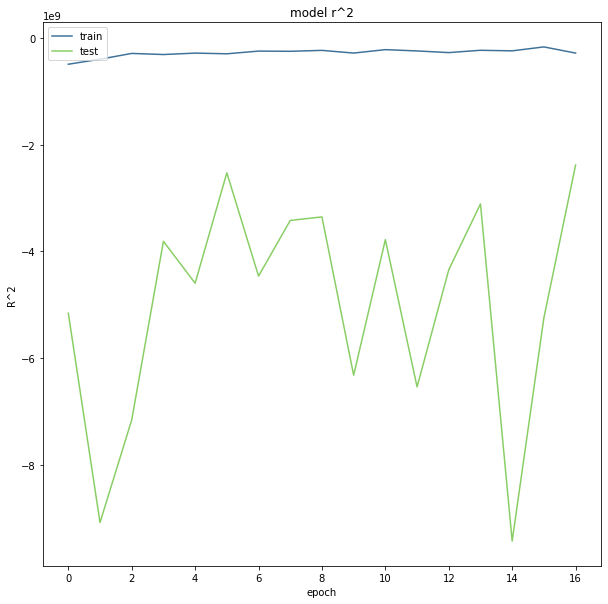

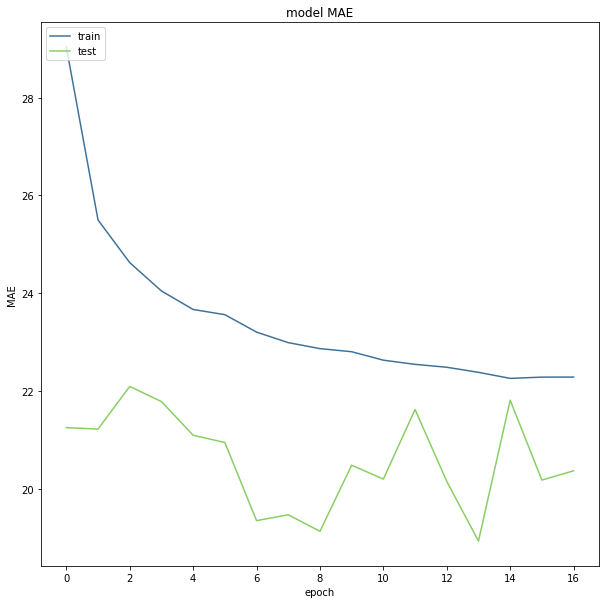

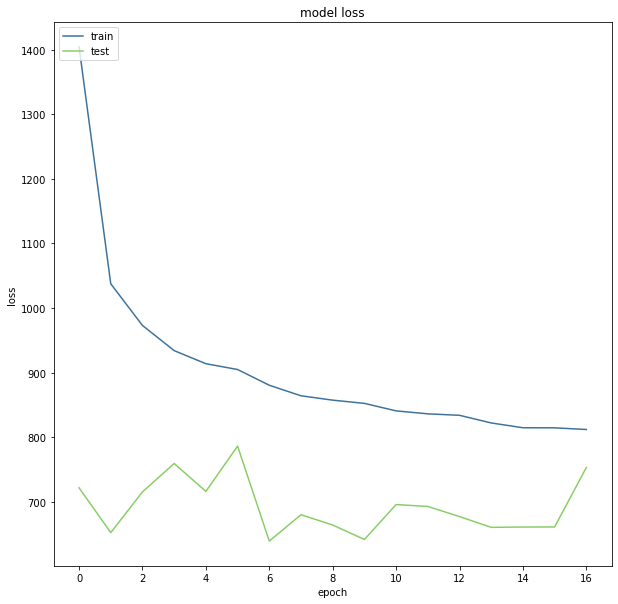

In [15]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['r2_keras'], color="#3f729a")
plt.plot(result.history['val_r2_keras'], color="#89ce65")
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['mae'], color="#3f729a")
plt.plot(result.history['val_mae'], color="#89ce65")
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['loss'], color="#3f729a")
plt.plot(result.history['val_loss'], color="#89ce65")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_regression_loss.png")

In [19]:
predictions = model_MLP.predict(train_all)

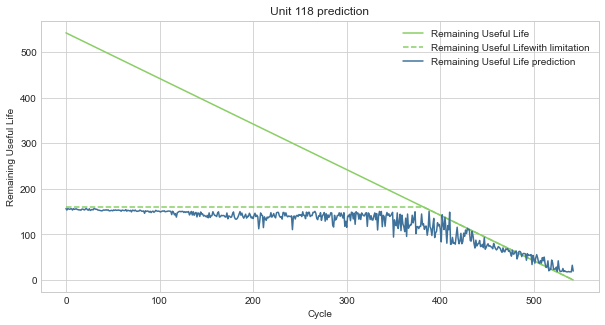

In [26]:
## Model predictions for the train set

train_df['RUL_predict'] = predictions

train_df['RUL_tuned'] = Y_tuned

unit = 118


fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)

ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_tuned'], color = "#89ce65", label = "Remaining Useful Lifewith limitation", linestyle = '--')
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")
ax.set_ylabel("Remaining Useful Life")
ax.set_xlabel("Cycle")
ax.set_title("Unit 118 prediction")

ax.legend()




MAE: 74.26885223388672

R^2: -124.38160705566406
[[ 39.193142]
 [ 73.41123 ]
 [ 97.065605]
 [108.319496]
 [ 97.862946]
 [130.26067 ]
 [119.52925 ]
 [ 21.965923]
 [ 90.24823 ]
 [152.0116  ]
 [149.35379 ]
 [ 19.790253]
 [ 72.21216 ]
 [121.238655]
 [ 25.671015]
 [126.53439 ]
 [129.36954 ]
 [ 88.73724 ]
 [153.48111 ]
 [ 88.0905  ]
 [126.79561 ]
 [ 19.790253]
 [ 42.697975]
 [ 98.58228 ]
 [ 38.07259 ]
 [121.3568  ]
 [ 78.74918 ]
 [152.70883 ]
 [ 88.27719 ]
 [121.914246]
 [ 24.178444]
 [ 41.1143  ]
 [147.27281 ]
 [110.46748 ]
 [ 37.395714]
 [103.97032 ]
 [ 74.44248 ]
 [ 37.879036]
 [103.80493 ]
 [ 19.790253]
 [130.54927 ]
 [ 23.709248]
 [123.57707 ]
 [ 42.756542]
 [126.73325 ]
 [129.12842 ]
 [ 41.60832 ]
 [ 68.07622 ]
 [ 36.892494]
 [106.49983 ]
 [146.05228 ]
 [155.55472 ]
 [143.7602  ]
 [106.23758 ]
 [146.15742 ]
 [113.89836 ]
 [139.86673 ]
 [ 19.790253]
 [147.56715 ]
 [122.533615]
 [ 32.618195]
 [ 38.504353]
 [135.80688 ]
 [ 80.80173 ]
 [ 24.997288]
 [105.5818  ]
 [ 40.350555]
 [ 54.60604 

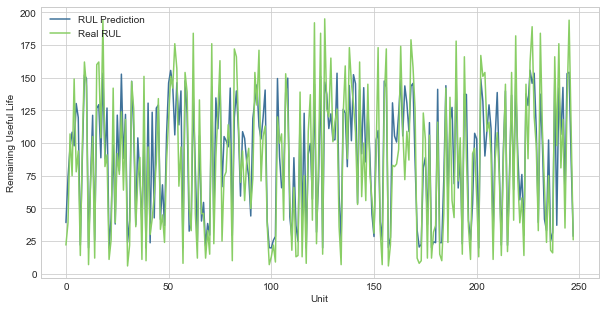

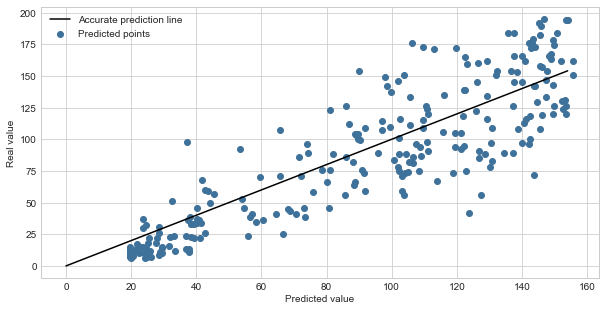

In [21]:
#Model evaluation - Part 1

if os.path.isfile('C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Python/pm_nasa_cmapss/Final_models/MLP/MLP_regression_PCA_1_FD4_tuned.h5'):
    
    estimator = load_model('C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Python/pm_nasa_cmapss/Final_models/MLP/MLP_regression_PCA_1_FD4_tuned.h5',custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(test_proof[train_cols], RUL_test.to_numpy()[:,0], verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(test_proof[train_cols])
    y_true_test = test_proof['RUL'].to_numpy()

    print(y_pred_test)
    print(y_true_test)

    #test_set = pd.DataFrame(y_pred_test)
    #test_set.to_csv('submit_test.csv', index = None)

    plt.style.use('seaborn-whitegrid')

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="#3f729a")
    plt.plot(y_true_test, color="#89ce65")
    plt.ylabel('Remaining Useful Life')
    plt.xlabel('Unit')
    plt.legend(['RUL Prediction', 'Real RUL'], loc='best')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

    #Plot the results

    fig_predict = plt.figure(figsize = (10,5))
    plt.scatter(y_pred_test, y_true_test, color = "#3f729a")
    plt.plot(range(y_pred_test.max().astype(int)),range(y_pred_test.max().astype(int)), color = "black")
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.legend(['Accurate prediction line', 'Predicted points'])
    plt.show()


In [22]:
## Challenge score analysis

Computed_Score(y_true_test, y_pred_test[:,0])

7135.533385591254

The model score is: 7135.533385591257
The model accuracy is: 28.2258064516129
The model MAE is: 21.813854586693548
The model MSE is : 716.9504376787892
The model Mean Absolute Percentage Error (MAPE) is: 28.999722728981
The model Mean Absolute Percentage Error 2 (MAPE_2) is: 7.08141950942723


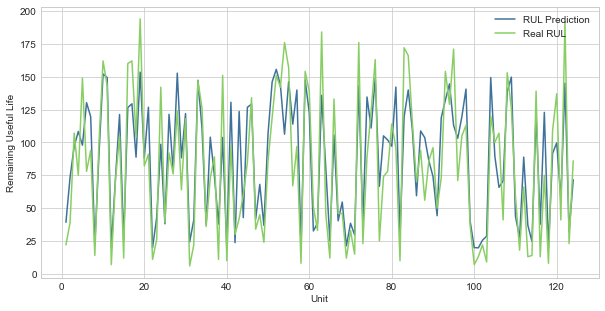

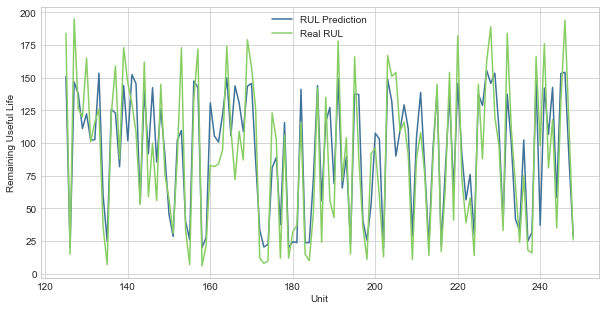

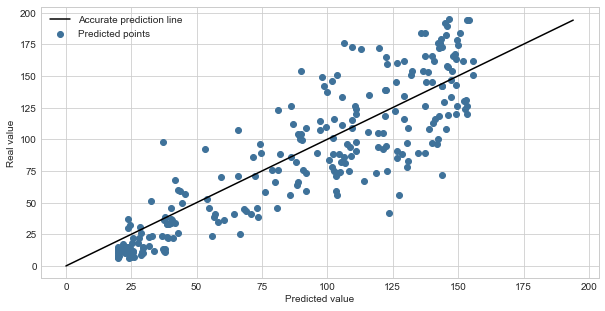

(7135.533385591257,
 28.2258064516129,
 21.813854586693548,
 716.9504376787892,
 28.999722728981,
 7.08141950942723)

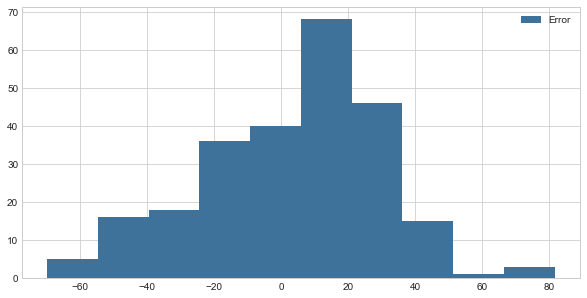

In [23]:
## Model evaluation - Part 2

perform_func(y_pred_test[:,0], y_true_test, test_df.groupby('Unit').max()['max'].to_numpy())

In [32]:
## Error analysis by differencing the RUL tu predict and the information we have about the turbine

test_lastcycle = test_proof

print(test_lastcycle.shape, y_pred_test.shape, y_true_test.shape)

error_df = pd.DataFrame()
error_df[['Unit','Cycle','RUL']] = test_lastcycle[['Unit','Cycle','RUL']]
error_df['error'] =  np.abs(y_pred_test[:,0] - y_true_test)

error_df['Group'] = 0
error_df.loc[error_df['Cycle'] <= 20, 'Group'] = 1
error_df.loc[(error_df['Cycle'] <= 40) & (error_df['Cycle'] > 20) , 'Group'] = 2
error_df.loc[(error_df['Cycle'] <= 60) & (error_df['Cycle'] > 40) , 'Group'] = 3
error_df.loc[(error_df['Cycle'] <= 80) & (error_df['Cycle'] > 60) , 'Group'] = 4
error_df.loc[(error_df['Cycle'] <= 100) & (error_df['Cycle'] > 80) , 'Group'] = 5
error_df.loc[(error_df['Cycle'] <= 120) & (error_df['Cycle'] > 100) , 'Group'] = 6
error_df.loc[(error_df['Cycle'] <= 140) & (error_df['Cycle'] > 120) , 'Group'] = 7
error_df.loc[(error_df['Cycle'] > 140) , 'Group'] = 8

error_df['Group_RUL'] = 0
error_df.loc[error_df['RUL'] <= 20, 'Group_RUL'] = 1
error_df.loc[(error_df['RUL'] <= 40) & (error_df['RUL'] > 20) , 'Group_RUL'] = 2
error_df.loc[(error_df['RUL'] <= 60) & (error_df['RUL'] > 40) , 'Group_RUL'] = 3
error_df.loc[(error_df['RUL'] <= 80) & (error_df['RUL'] > 60) , 'Group_RUL'] = 4
error_df.loc[(error_df['RUL'] <= 100) & (error_df['RUL'] > 80) , 'Group_RUL'] = 5
error_df.loc[(error_df['RUL'] <= 120) & (error_df['RUL'] > 100) , 'Group_RUL'] = 6
error_df.loc[(error_df['RUL'] <= 140) & (error_df['RUL'] > 120) , 'Group_RUL'] = 7
error_df.loc[(error_df['RUL'] <= 160) & (error_df['RUL'] > 140) , 'Group_RUL'] = 8
error_df.loc[(error_df['RUL'] <= 180) & (error_df['RUL'] > 160) , 'Group_RUL'] = 9
error_df.loc[(error_df['RUL'] > 180) , 'Group_RUL'] = 10

(248, 21) (248, 1) (248,)


In [33]:
error_grouped  = error_df.groupby('Group').mean()

error_grouped_RUL = error_df.groupby('Group_RUL').mean()

error_grouped_RUL

,Unit,Cycle,RUL,error,Group
Group_RUL,,,,,
1,128.350000,194.850000,11.650000,13.567803,7.800000
2,116.724138,235.172414,30.241379,12.254159,7.862069
3,122.909091,206.181818,50.500000,26.750809,7.409091
4,111.727273,171.227273,72.181818,26.763136,7.318182
5,125.085714,167.028571,90.742857,25.515974,6.571429
6,137.103448,158.965517,111.137931,17.729641,6.586207
7,116.842105,120.157895,129.631579,21.145648,5.105263
8,108.909091,110.818182,150.090909,21.269789,5.181818
9,135.380952,100.571429,169.571429,32.099499,4.761905


In [29]:
print(error_grouped_RUL)

Unit       Cycle         RUL      error     Group
Group_RUL                                                         
1          128.350000  194.850000   11.650000  13.567803  7.800000
2          116.724138  235.172414   30.241379  12.254159  7.862069
3          122.909091  206.181818   50.500000  26.750809  7.409091
4          111.727273  171.227273   72.181818  26.763136  7.318182
5          125.085714  167.028571   90.742857  25.515974  6.571429
6          137.103448  158.965517  111.137931  17.729641  6.586207
8          116.842105  120.157895  129.631579  21.145648  5.105263
9          108.909091  110.818182  150.090909  21.269789  5.181818
10         135.380952  100.571429  169.571429  32.099499  4.761905
11         153.555556  112.000000  188.666667  42.603955  4.888889


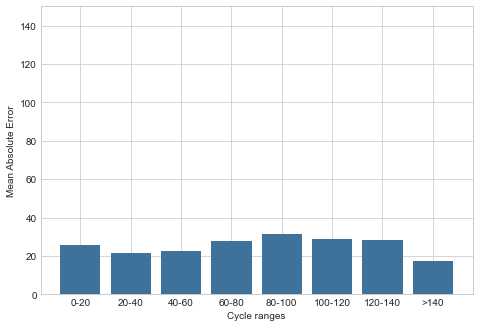

In [30]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['0-20','20-40', '40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Cycle ranges")
plt.ylim(0,150)
plt.show()


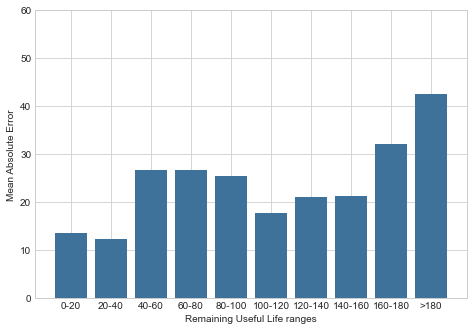

In [34]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['0-20','20-40', '40-60', '60-80', '80-100', '100-120','120-140','140-160','160-180', '>180']
errors = error_grouped_RUL['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Remaining Useful Life ranges")
plt.ylim(0,60)
plt.show()